# 6. Quantum Phase Estimation vs. Hadamard Test

In [258]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

## Table of Contents
* [Hadamard Test Simulation](#HTsim)
* [Hadamard Test Quantum Computer](#HTqc)
* [Quantum Phase Estimation Simulation](#QPEsim)
* [Quantum Phase Estimation Quantum Computer](#QPEqc)

## Hadamard Test Simulation <a name="HTsim"></a>

In [18]:
angle = 1/3 #Exact value of phi to estimate
angle = angle%(2*pi)
print("Angle: ",angle, "rad")

Angle:  0.3333333333333333 rad


In [84]:
def re_HT(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0$\u27e9')    
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9') 
    circuit.cp(2*pi*theta,0,1) # rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_2$\u27e9') 
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

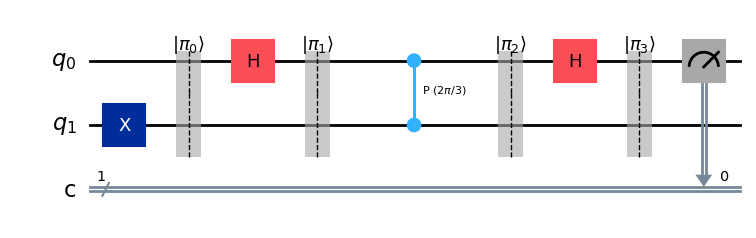

In [85]:
HTre = re_HT(angle)
HTre.draw('mpl')

In [86]:
def im_HT(theta):
    circuit = QuantumCircuit(2,1) #Create circuit with 2 qubits and 1 classical bit
    circuit.x(1) #Apply pauli-x gate to q1 to put it to 1 state
    circuit.barrier(label='$|π_0\u27e9$')
    circuit.h(0) #Apply hadamard gate to q0 to put it into + state
    circuit.barrier(label='$|π_1$\u27e9')
    circuit.s(0) #Apply phase gate to make imaginary
    circuit.barrier(label='$|π_2$\u27e9')
    circuit.cp(2*pi*theta,0,1) #Rotates q0 2*pi*theta radians if q1 is 1
    circuit.barrier(label='$|π_3$\u27e9')
    circuit.h(0) #Apply second hadamard gate to q0 to ensure the value phi affects our output
    circuit.barrier(label='$|π_4$\u27e9')
    circuit.measure(0,0) #Measure q0
    return circuit

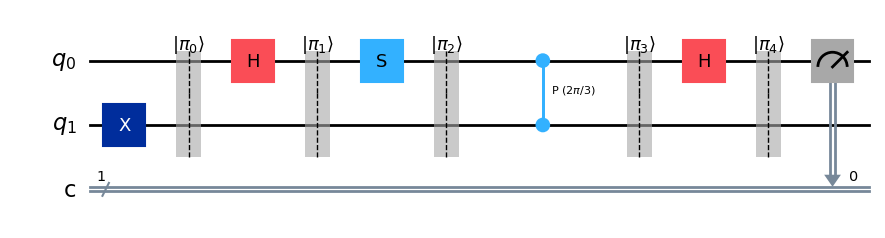

In [87]:
HTim = im_HT(angle)
HTim.draw('mpl')

In [88]:
sim = AerSimulator() # set simulator
shots = 1000

In [89]:
transRe = transpile(HTre, sim) # transpile real hadamard test circuit
resultRe = sim.run(transRe, shots = shots).result() # run transpiled circuit
countsRe = resultRe.get_counts() # retreive counts after measurement

transIm = transpile(HTim, sim) # transpile imaginary hadamard test circuit
resultIm = sim.run(transIm, shots = shots).result() # run transpiled circuit
countsIm = resultIm.get_counts() # retreive counts after measurement

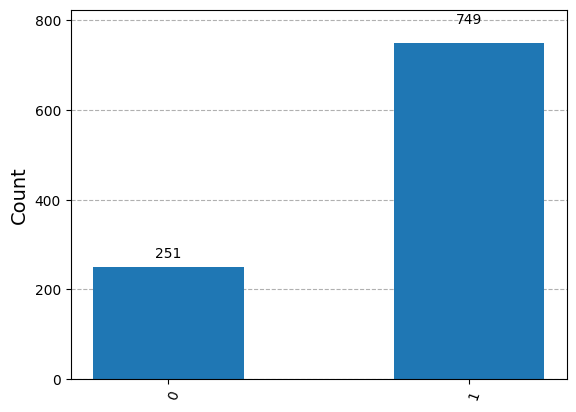

In [90]:
plot_histogram(countsRe)

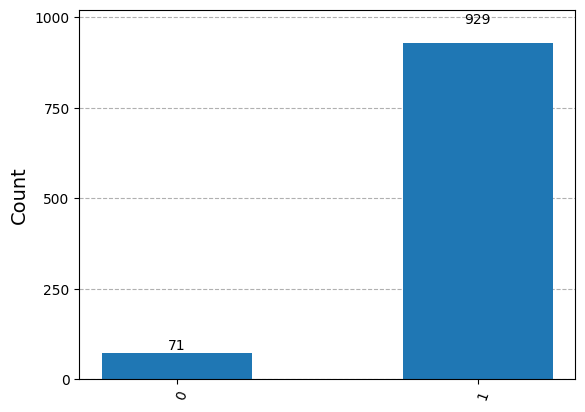

In [91]:
plot_histogram(countsIm)

In [92]:
equation_number = 1 # use cosine to determine angle and sine to determine sign
# equation_number = 2 # use sine to determine angle and cosine to determine sign
# equation_number = 3 # use tan to determine angle
re_p0 = re_p1 = im_p0 = im_p1 = 0

if countsRe.get('0') is not None:
    re_p0 = countsRe['0']/shots
    
if countsRe.get('1') is not None:
    re_p1 = countsRe['1']/shots
    
if countsIm.get('0') is not None:
    im_p0 = countsIm['0']/shots
    
if countsIm.get('1') is not None:
    im_p1 = countsIm['1']/shots

re = re_p0 - re_p1
im = im_p1 - im_p0

ans = 0
if equation_number == 1:
    cos_angle = np.arccos(re)
    if  np.arcsin(im)<0:
        ans = 2*pi - cos_angle
    else:
        ans = cos_angle
elif equation_number == 2:
    sin_angle = np.arcsin(im)
    if  np.arccos(re)>pi/2:
        ans = pi - sin_angle
    else:
        ans = sin_angle
else:
    ans = np.arctan2(im,re)

# make sure the angle is positive for comparision
if ans < 0: ans = ans + 2*pi
print("\nEstimated phase angle:\t", ans/(2*pi))
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.3329660251195436
Exact phase angle:	 0.3333333333333333


In [93]:
# Construct a graph of error verses number of shots
timesHSre = []
timesHSim = []
trials = np.logspace(3, 5, 20)
Ns = []
errorHS = []
for num_of_shots in trials:
    num_of_shots = int(num_of_shots)
    Retrans = transpile(HTre, sim) # transpile real hadamard test circuit
    Reresult = sim.run(Retrans, shots = num_of_shots).result() # run transpiled circuit
    Recounts = Reresult.get_counts() # retreive counts after measurement
    
    Imtrans = transpile(HTim, sim) # transpile imaginary hadamard test circuit
    Imresult = sim.run(Imtrans, shots = num_of_shots).result() # run transpiled circuit
    Imcounts = Imresult.get_counts() # retreive counts after measurement

    timesHSre.append(Reresult.time_taken) # append circuit run times to a list
    timesHSim.append(Imresult.time_taken)
    
    p0Re = p1Re = p0Im = p1Im = 0

    # obtain probabilities from counts
    if Recounts.get('0') is not None:
        p0Re = Recounts['0']/num_of_shots
        
    if Recounts.get('1') is not None:
        p1Re = Recounts['1']/num_of_shots
        
    if Imcounts.get('0') is not None:
        p0Im = Imcounts['0']/num_of_shots
        
    if Imcounts.get('1') is not None:
        p1Im = Imcounts['1']/num_of_shots

    # compute expectation values from counts
    rex = p0Re - p1Re
    imx = p0Im - p1Im

    # compute monte-carlo error
    errorHS.append((p0Re*(1 - p0Re)/num_of_shots)**(0.5))
    Ns.append(num_of_shots**(-0.5))

timesHS = np.array(timesHSre) + np.array(timesHSim)
errorHS=np.array(errorHS)

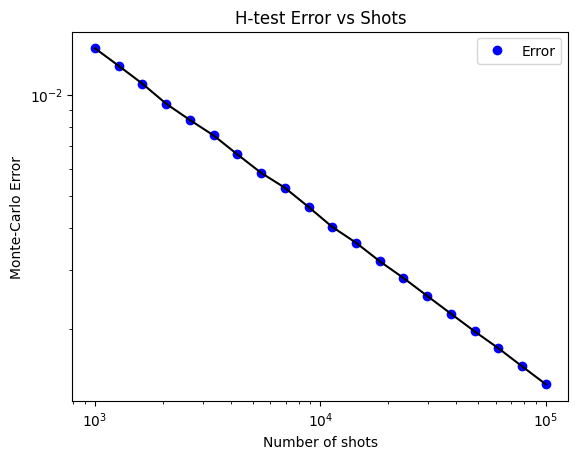

In [94]:
plt.loglog(trials, errorHS, 'bo', label = 'Error')
plt.loglog(trials, errorHS, 'k-')
plt.title("H-test Error vs Shots")
plt.xlabel("Number of shots")
plt.ylabel("Monte-Carlo Error")
plt.legend(loc='upper right')
plt.show()

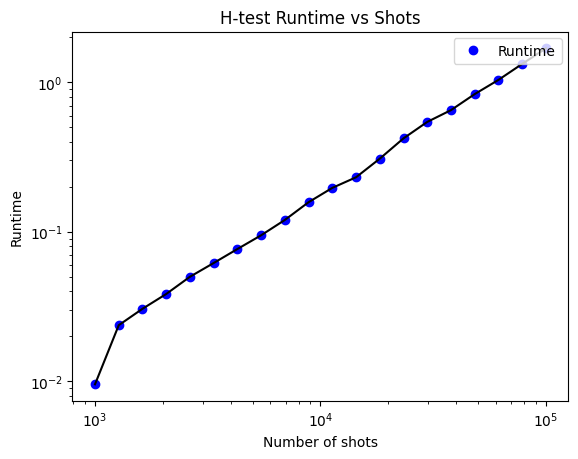

In [95]:
plt.loglog(trials, timesHS, 'bo', label = 'Runtime')
plt.loglog(trials, timesHS, 'k-')
plt.title("H-test Runtime vs Shots")
plt.xlabel("Number of shots")
plt.ylabel("Runtime")
plt.legend(loc='upper right')
plt.show()

## Hadamard Test Quantum Computer <a name="HTqc"></a>

In [203]:
token = "13f6b456c343128a31873713cd6ed24391e20dc710cd7a1c517947233cf19d94589cd00f09dcc3d2075c8b8ae92ad48247a682c38bb61f4bac09ace18d6e305b"

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='rpi-rensselaer/general/general',
    token=token
)

backend = service.backend("ibm_rensselaer")
sampler = Sampler(backend)

In [204]:
HTre = re_HT(angle)
HTim = im_HT(angle)

In [205]:
HTre_trans = transpile(HTre, backend = backend, optimization_level = 3) # transpile real HT circuit
twodepth1 = HTre_trans.depth(lambda x: x.operation.name == "ecr") # get number of 2-qubit gates in path

HTim_trans = transpile(HTim, backend = backend, optimization_level = 3) # transpile imaginary HT circuit
twodepth2 = HTim_trans.depth(lambda x: x.operation.name == "ecr") # get number of 2-qubit gates in path

print(twodepth1, twodepth2)

2 2


In [206]:
# run both HT circuits on hardware
reHT_job = sampler.run([HTre_trans], shots=shots)
imHT_job = sampler.run([HTim_trans], shots=shots)

In [207]:
# get results for circuits
re_result = reHT_job.result()[0]
im_result = imHT_job.result()[0]

# gather counts for circuit
re_counts = re_result.data.c.get_counts()
im_counts = im_result.data.c.get_counts()

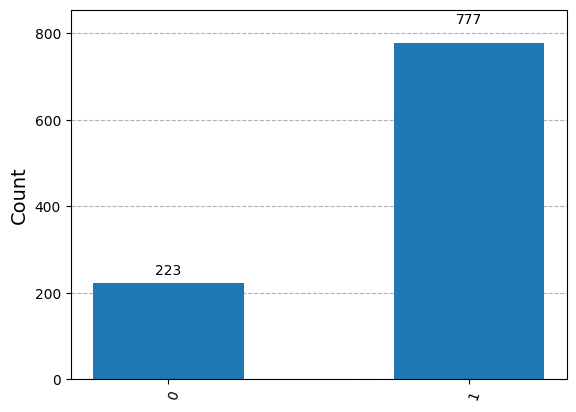

In [208]:
plot_histogram(re_counts)

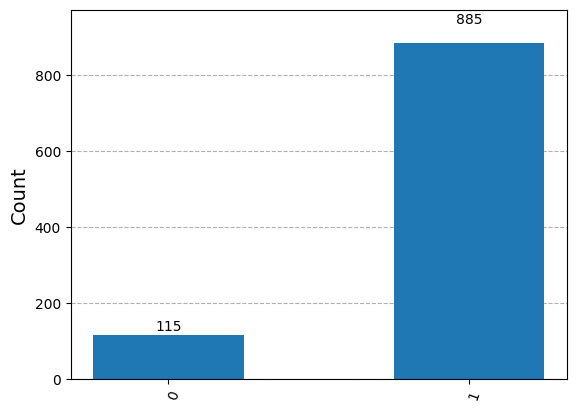

In [209]:
plot_histogram(im_counts)

In [210]:
print('Real HT Runtime: ', reHT_job.usage_estimation.get('quantum_seconds'), 'sec')
print('Imaginary HT Runtime: ', imHT_job.usage_estimation.get('quantum_seconds'), 'sec')

Real HT Runtime:  2.1972422704295234 sec
Imaginary HT Runtime:  2.1972422704295234 sec


In [215]:
equation_number = 1 # use cosine to determine angle and sine to determine sign
# equation_number = 2 # use sine to determine angle and cosine to determine sign
# equation_number = 3 # use tan to determine angle
num_of_shots = shots
re_p0 = re_p1 = im_p0 = im_p1 = 0

if re_counts.get('0') is not None:
    re_p0 = re_counts['0']/num_of_shots
    
if re_counts.get('1') is not None:
    re_p1 = re_counts['1']/num_of_shots
    
if im_counts.get('0') is not None:
    im_p0 = im_counts['0']/num_of_shots
    
if im_counts.get('1') is not None:
    im_p1 = im_counts['1']/num_of_shots

re = re_p0 - re_p1
im = im_p1 - im_p0

ans = 0
if equation_number == 1:
    cos_angle = np.arccos(re)
    if  np.arcsin(im)<0:
        ans = 2*pi - cos_angle
    else:
        ans = cos_angle
elif equation_number == 2:
    sin_angle = np.arcsin(im)
    if  np.arccos(re)>pi/2:
        ans = pi - sin_angle
    else:
        ans = sin_angle
else:
    ans = np.arctan2(im,re)

# make sure the angle is positive for comparision
if ans < 0: ans = ans + 2*pi
print("\nEstimated phase angle:\t", ans/(2*pi))
print("Exact phase angle:\t", angle)


Estimated phase angle:	 0.34344962459921863
Exact phase angle:	 0.3333333333333333


In [216]:
trials = np.logspace(3, 5, 20)
Ns = []
errorHQC = []
timesHQCre = []
timesHQCim = []
for num_of_shots in trials:
    num_of_shots = int(num_of_shots)

    re_job = sampler.run([HTre_trans], shots=num_of_shots) # run both circuits on hardware
    im_job = sampler.run([HTim_trans], shots=num_of_shots)

    Reresult = re_job.result()[0] # gather results for both circuits
    Imresult = im_job.result()[0]

    Recounts = Reresult.data.c.get_counts() # gather counts for both circuits
    Imcounts = Imresult.data.c.get_counts()
    
    timesHQCre.append(re_job.usage_estimation.get('quantum_seconds')) # estimate run time of each circuit
    timesHQCim.append(im_job.usage_estimation.get('quantum_seconds'))

    re_p0 = re_p1 = im_p0 = im_p1 = 0

    # compute probabilities
    if re_counts.get('0') is not None:
        re_p0 = Recounts['0']/num_of_shots
        
    if re_counts.get('1') is not None:
        re_p1 = Recounts['1']/num_of_shots
        
    if im_counts.get('0') is not None:
        im_p0 = Imcounts['0']/num_of_shots
        
    if im_counts.get('1') is not None:
        im_p1 = Imcounts['1']/num_of_shots

    # compute expecation values
    re = re_p0 - re_p1
    im = im_p1 - im_p0

    # append error and convergence rate
    errorHQC.append((re_p0*(1 - re_p0)/num_of_shots)**(0.5))
    Ns.append(num_of_shots**(-0.5))

In [217]:
timesHQC = np.array(timesHQCre) + np.array(timesHQCre)
errorHQC=np.array(errorHQC)

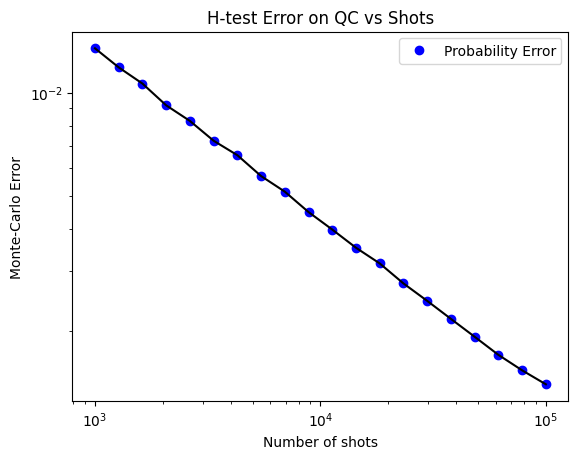

In [218]:
plt.loglog(trials, errorHQC, 'bo', label = 'Probability Error')
plt.loglog(trials, errorHQC, 'k-')
plt.title("H-test Error on QC vs Shots")
plt.xlabel("Number of shots")
plt.ylabel("Monte-Carlo Error")
plt.legend(loc='upper right')
plt.show()

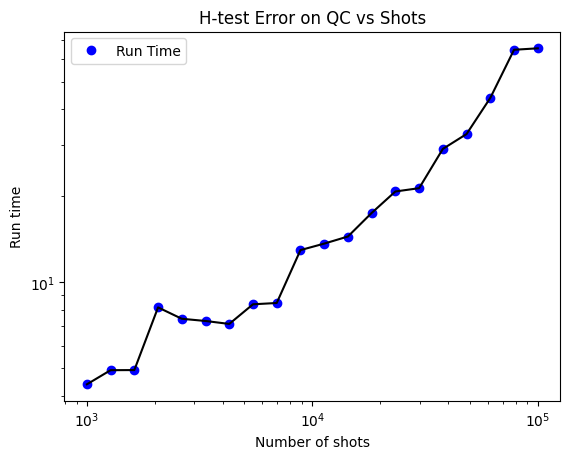

In [221]:
plt.loglog(trials, timesHQC, 'bo', label = 'Run Time')
plt.loglog(trials, timesHQC, 'k-')
plt.title("H-test Error on QC vs Shots")
plt.xlabel("Number of shots")
plt.ylabel("Run time")
plt.legend(loc='upper left')
plt.show()

## Quantum Phase Estimation Simulation <a name="QPEsim"></a>

In [177]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.measure(i,i)

In [178]:
ancilla_bits = 4
angle = 1/3

In [179]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.3333333333333333
Binary Representation of the phase angle:  0.0101


In [191]:
def QPE(anc, angle):
    qc = QuantumCircuit(anc+1, anc)
    setup(qc, anc)
    qc.x(anc)
    qc.barrier()
    for i in range(anc):
        qc.cp((2*pi*angle)*2**(i), anc,i)
    
    add_inv_fourier_transform(qc,anc)
    
    #qr_ancilla = QuantumRegister(ancilla_bits)
    # print(qr_ancilla
    
    #qc.append(QFT(ancilla_bits).inverse(), ancilla_bits)
    qc.compose(QFT(anc, inverse = True), range(anc))
    return qc

In [184]:
from qiskit.circuit.library import QFT

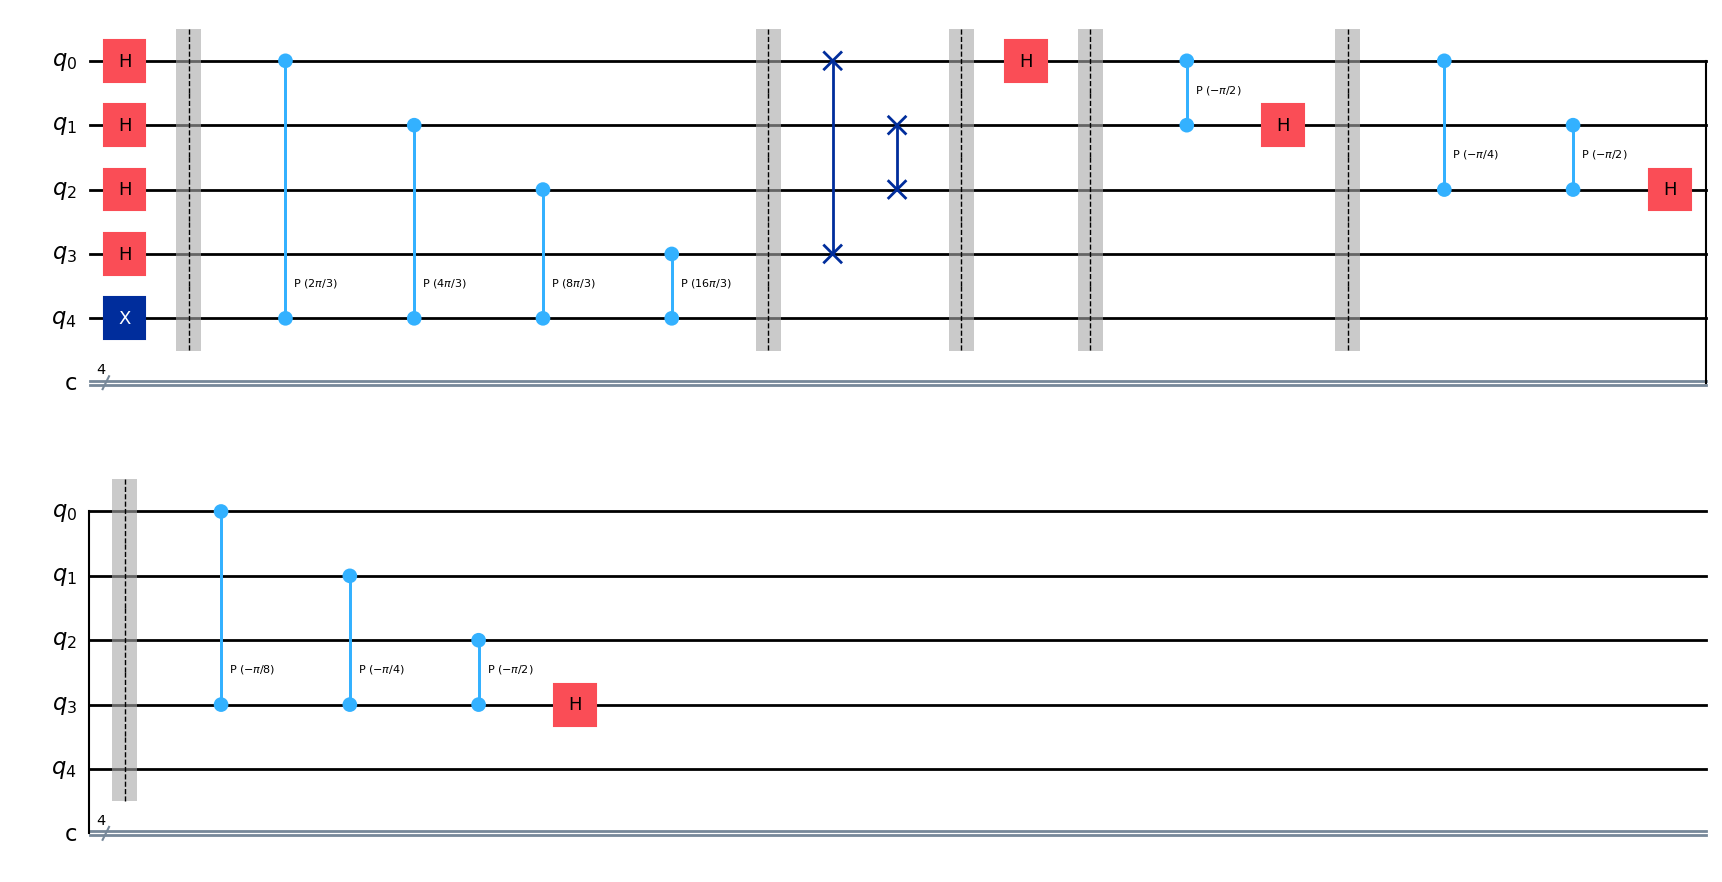

In [194]:
qc = QPE(ancilla_bits, angle)
qc.draw('mpl')

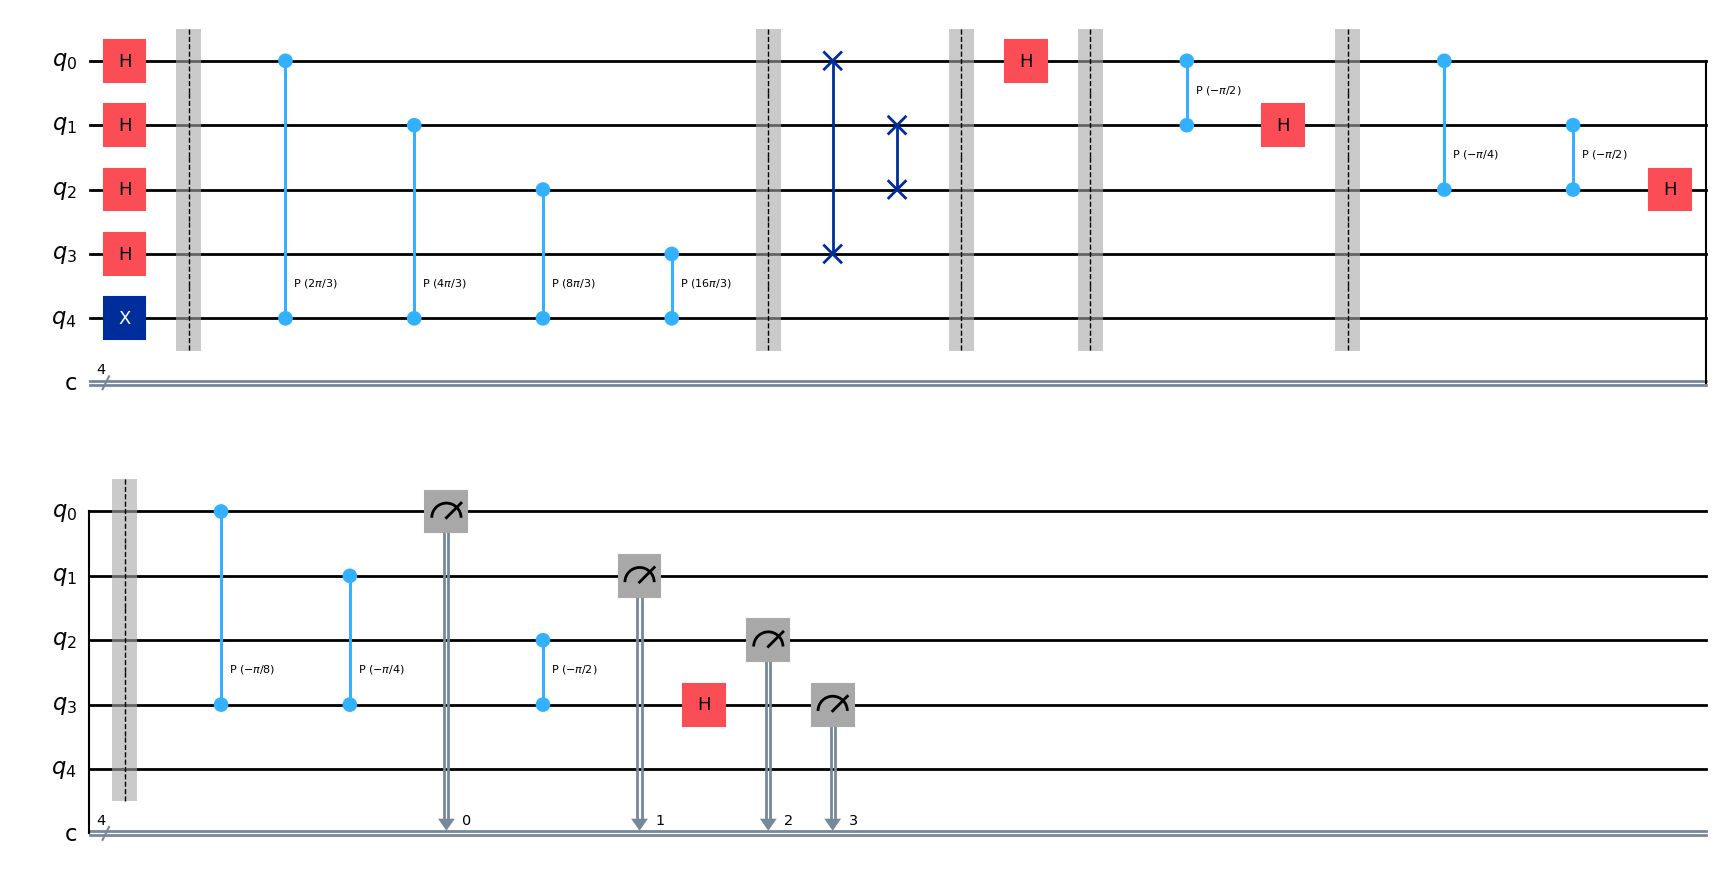

In [195]:
measure(qc, ancilla_bits)
qc.draw('mpl')

In [196]:
qctrans = transpile(qc, sim)
result = sim.run(qctrans, shots=1000).result()   
counts = result.get_counts()

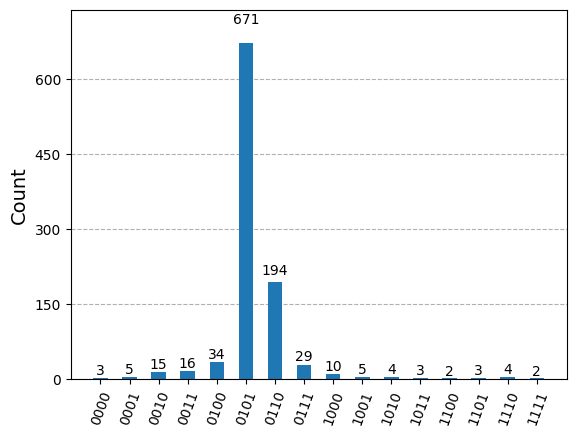

In [197]:
plot_histogram(counts)

In [198]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.0101
Decimal Number with Equivalent Value: 0.3125


In [199]:
anc_bits = np.arange(1,21,1)
est = []
timesQPES = []
for bit in anc_bits:
    qc = QPE(bit, angle)
    measure(qc, bit)
    
    qctrans = transpile(qc, sim)
    result = sim.run(qctrans, shots=1000).result()   
    counts = result.get_counts()
    times = result.time_taken
    timesQPES.append(times)
    
    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    est.append(decimal_num)
errorQPES = abs(angle - np.array(est))

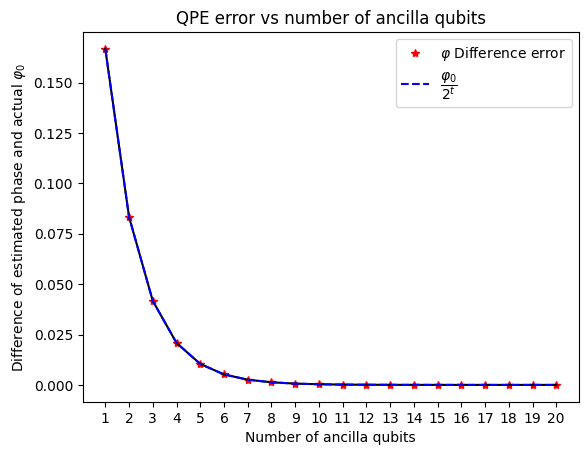

In [200]:
plt.plot(anc_bits,errorQPES, 'r*', label = '$\u03c6$ Difference error')
plt.plot(anc_bits,errorQPES, 'k-')
plt.plot(anc_bits, angle/((2)**(anc_bits)), 'b--', label = '$\dfrac{\u03c6_0}{2^t}$')
plt.xticks(anc_bits)

plt.xlabel('Number of ancilla qubits')
plt.ylabel('Difference of estimated phase and actual $\u03c6_0$')
plt.title('QPE error vs number of ancilla qubits')
plt.legend(loc='upper right')

plt.show()

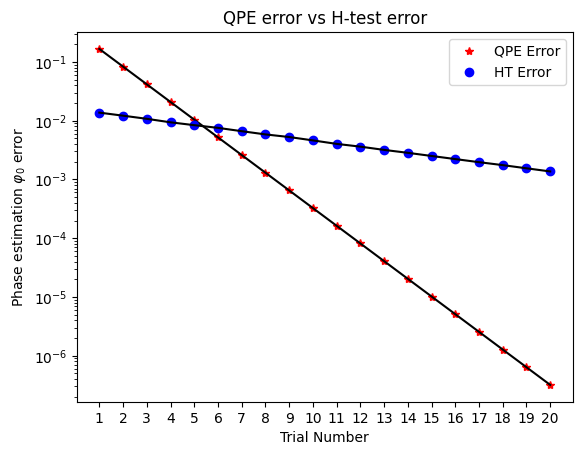

In [201]:
plt.plot(anc_bits,errorQPES, 'r*', label = 'QPE Error')
plt.plot(anc_bits,errorQPES, 'k-')
plt.plot(anc_bits, errorHS, 'bo', label = 'HT Error')
plt.plot(anc_bits, errorHS, 'k-')
plt.xticks(anc_bits)
plt.yscale('log')

plt.xlabel('Trial Number')
plt.ylabel('Phase estimation $\u03c6_0$ error')
plt.title('QPE error vs H-test error')
plt.legend(loc='upper right')

plt.show()

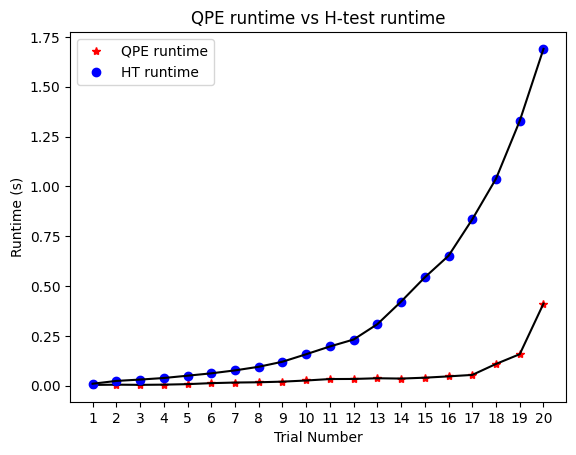

In [202]:
plt.plot(anc_bits,timesQPES,'r*', label = 'QPE runtime')
plt.plot(anc_bits,timesQPES,'k-')
plt.plot(anc_bits,np.array(timesHS), 'bo', label = 'HT runtime')
plt.plot(anc_bits,np.array(timesHS), 'k-')
plt.xticks(anc_bits)

plt.xlabel('Trial Number')
plt.ylabel('Runtime (s)')
plt.title('QPE runtime vs H-test runtime')
plt.legend(loc = 'upper left')
plt.show()


## Quantum Phase Estimation Quantum Computer <a name="QPEqc"></a>

In [244]:
ancilla_bits = 3
angle = 1/3
shots = 1000

In [245]:
print("Decimal Representation of the phase angle:", angle)
reading_angle = angle
print("Binary Representation of the phase angle:  0.", end="")
for i in range(1,ancilla_bits+1):
    if reading_angle - 1/2**i >= 0:
        reading_angle -= 1/2**i
        print("1", end="")
    else:
        print("0", end="")
print()

Decimal Representation of the phase angle: 0.3333333333333333
Binary Representation of the phase angle:  0.010


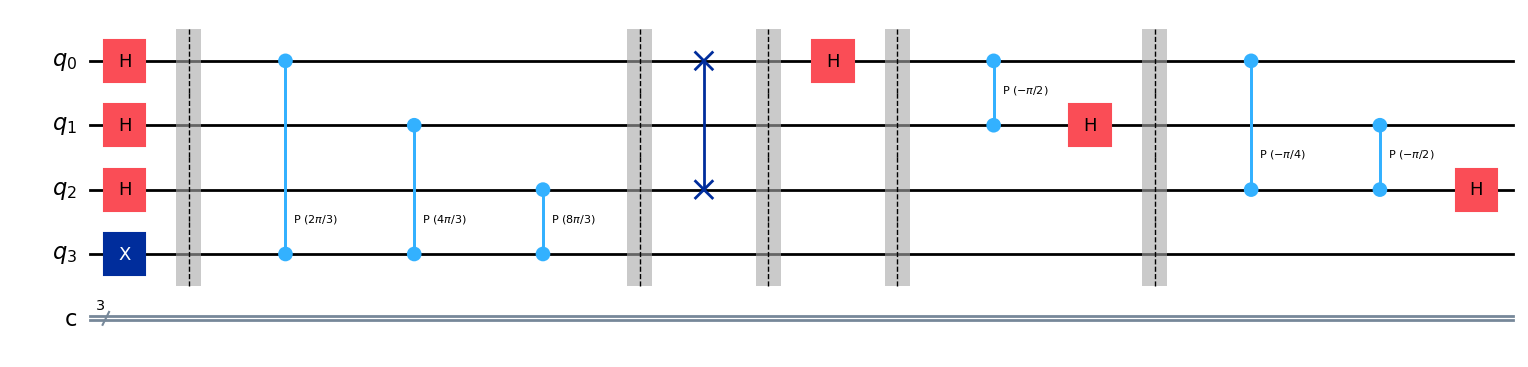

In [246]:
qc = QPE(ancilla_bits, angle)
qc.draw('mpl')

In [247]:
measure(qc, ancilla_bits)
#qc.draw('mpl')

In [248]:
qc_trans = transpile(qc, backend = backend, optimization_level=3)
twodepth = qc_trans.depth(lambda x: x.operation.name == "ecr")
print(twodepth)

16


In [249]:
QPE_job = sampler.run([qc_trans], shots = shots)

In [250]:
# get results for circuit
result = QPE_job.result()[0]

# gather counts for circuit
counts = result.data.c.get_counts()

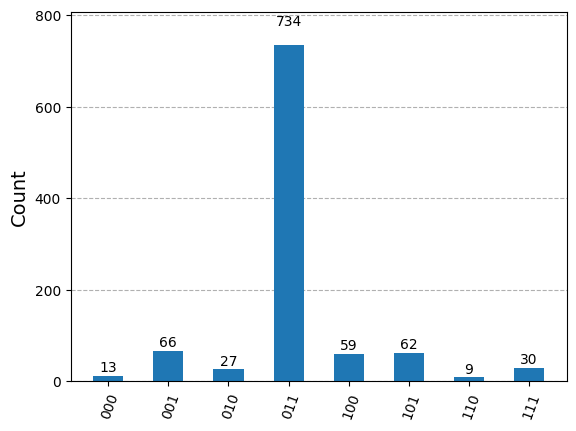

In [251]:
plot_histogram(counts)

In [252]:
binary_num = ''
max_num = 0
for key in counts:
    if (counts[key] > max_num):
        max_num = counts[key]
        binary_num = key
print("Binary Number with Maximum count:     0."+binary_num)
decimal_num = 0
for i in range(len(binary_num)):
    decimal_num += int(binary_num[i])/2**(i+1)
print("Decimal Number with Equivalent Value:",decimal_num)

Binary Number with Maximum count:     0.011
Decimal Number with Equivalent Value: 0.375


In [253]:
anc_bits = np.arange(1,21,1)
est = []
timesQPEQC = []
for bit in anc_bits:
    qc = QPE(bit, angle)
    measure(qc, bit)
    
    qctrans = transpile(qc, backend = backend, optimization_level=3)
    qc_job = sampler.run([qctrans], shots = shots)
    qcresult = qc_job.result()[0]
    
    timesQPEQC.append(qc_job.usage_estimation.get('quantum_seconds'))
    counts = qcresult.data.c.get_counts() 
    
    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    est.append(decimal_num)
errorQPEQC = abs(angle - np.array(est))

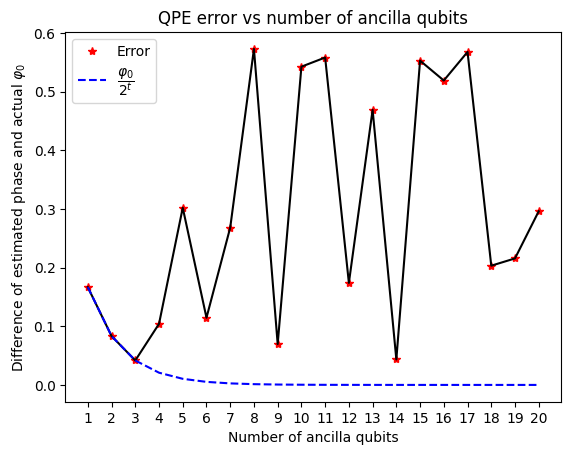

In [254]:
plt.plot(anc_bits,errorQPEQC, 'r*', label = 'Error')
plt.plot(anc_bits,errorQPEQC, 'k-')
plt.plot(anc_bits, angle/((2)**(anc_bits)), 'b--', label = '$\dfrac{\u03c6_0}{2^t}$')
plt.xticks(anc_bits)

plt.xlabel('Number of ancilla qubits')
plt.ylabel('Difference of estimated phase and actual $\u03c6_0$')
plt.title('QPE error vs number of ancilla qubits')
plt.legend(loc='upper left')

plt.show()

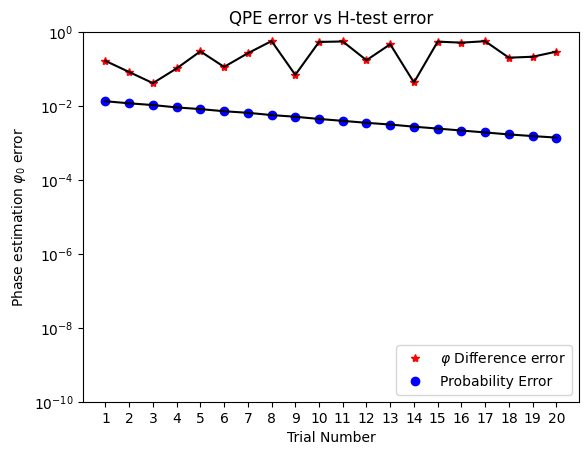

In [255]:
plt.plot(anc_bits,errorQPEQC, 'r*', label = '$\u03c6$ Difference error')
plt.plot(anc_bits,errorQPEQC, 'k-')
plt.plot(anc_bits, errorHQC, 'bo', label = 'Probability Error')
plt.plot(anc_bits, errorHQC, 'k-')
plt.xticks(anc_bits)
plt.yscale('log')

plt.xlabel('Trial Number')
plt.ylabel('Phase estimation $\u03c6_0$ error')
plt.title('QPE error vs H-test error')
plt.legend(loc='lower right')
plt.ylim(0.0000000001,1)

plt.show()

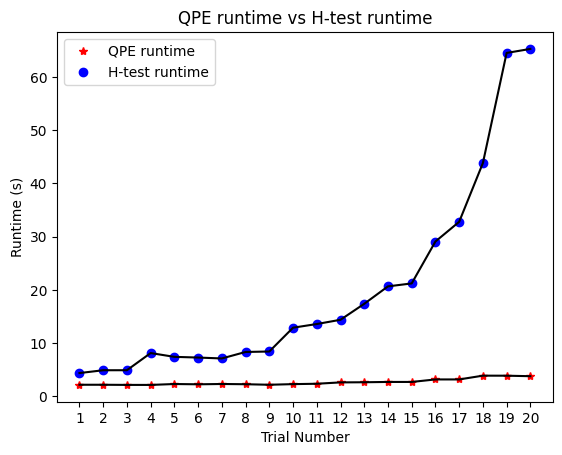

In [256]:
plt.plot(anc_bits,timesQPEQC,'r*', label = 'QPE runtime')
plt.plot(anc_bits,timesQPEQC,'k-')
plt.plot(anc_bits,timesHQC, 'bo', label = 'H-test runtime')
plt.plot(anc_bits,timesHQC, 'k-')
plt.xticks(anc_bits)

plt.xlabel('Trial Number')
plt.ylabel('Runtime (s)')
plt.title('QPE runtime vs H-test runtime')
plt.legend(loc = 'upper left')
plt.show()


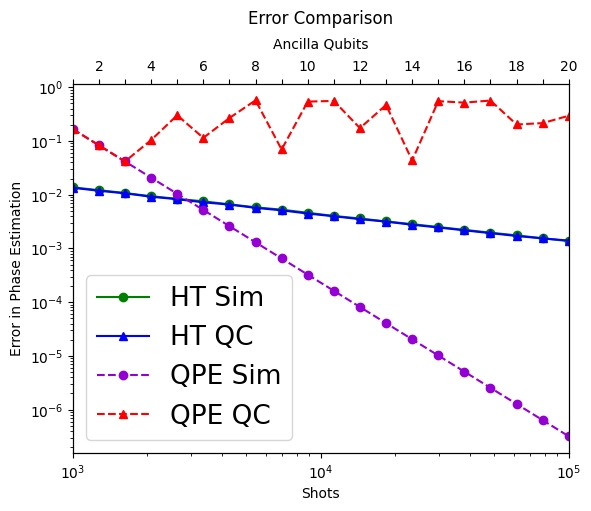

In [259]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials, errorHS, 'go-', label='HT Sim')
lin2, = ax.loglog(trials, errorHQC, 'b^-', label='HT QC')
lin3, = ax.loglog(trials, errorQPES, 'darkviolet', marker='o', ls='--', label='QPE Sim')
lin4, = ax.loglog(trials, errorQPEQC, 'r^--', label='QPE QC')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

# y log-scale
nticks = 9
maj_loc = ticker.LogLocator(numticks=nticks)
min_loc = ticker.LogLocator(subs='all', numticks=nticks)
ax2.yaxis.set_major_locator(maj_loc)
ax2.yaxis.set_minor_locator(min_loc)

ax.set_xlabel("Shots")
ax.set_ylabel("Error in Phase Estimation")
plt.title('Error Comparison', pad = 10)
ax.legend(loc='lower left', fontsize=19)

plt.show()

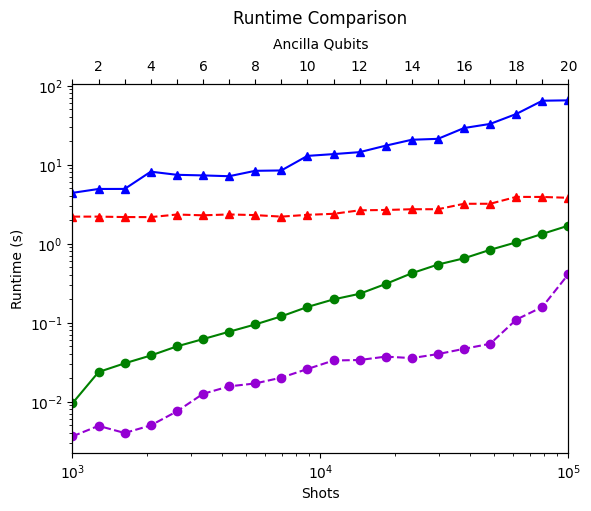

In [260]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials,timesQPES, color = 'darkviolet', marker ='o', ls = '--', label = 'QPE Sim Runtime')
lin2, = ax.loglog(trials,timesQPEQC,'r^', ls = '--', label = 'QPE QC Runtime')
lin3, = ax.loglog(trials,timesHS, 'go', ls = '-', label = 'HT Sim Runtime')
lin4, = ax.loglog(trials,timesHQC, 'b^', ls = '-', label = 'HT QC Runtime')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

ax.set_xlabel("Shots")
ax.set_ylabel("Runtime (s)")
plt.title('Runtime Comparison', pad = 10)

plt.show()

In [266]:
def deep(opt):
    for bit in anc_bit:
        qc = QPE(bit, angle)
        measure(qc, bit)

        qc_trans = transpile(qc, backend = backend, optimization_level=opt)
        twodepth = qc_trans.depth(lambda x: x.operation.name == "ecr")

        if opt == 0:           
            depth0.append(twodepth)
        elif opt == 1:           
            depth1.append(twodepth)
        elif opt == 2:           
            depth2.append(twodepth)
        else:
            depth3.append(twodepth)

In [267]:
anc_bit = np.arange(1,21,1)
depth0 = []
depth1 = []
depth2 = []
depth3 = []
deep(0)
deep(1)
deep(2)
deep(3)

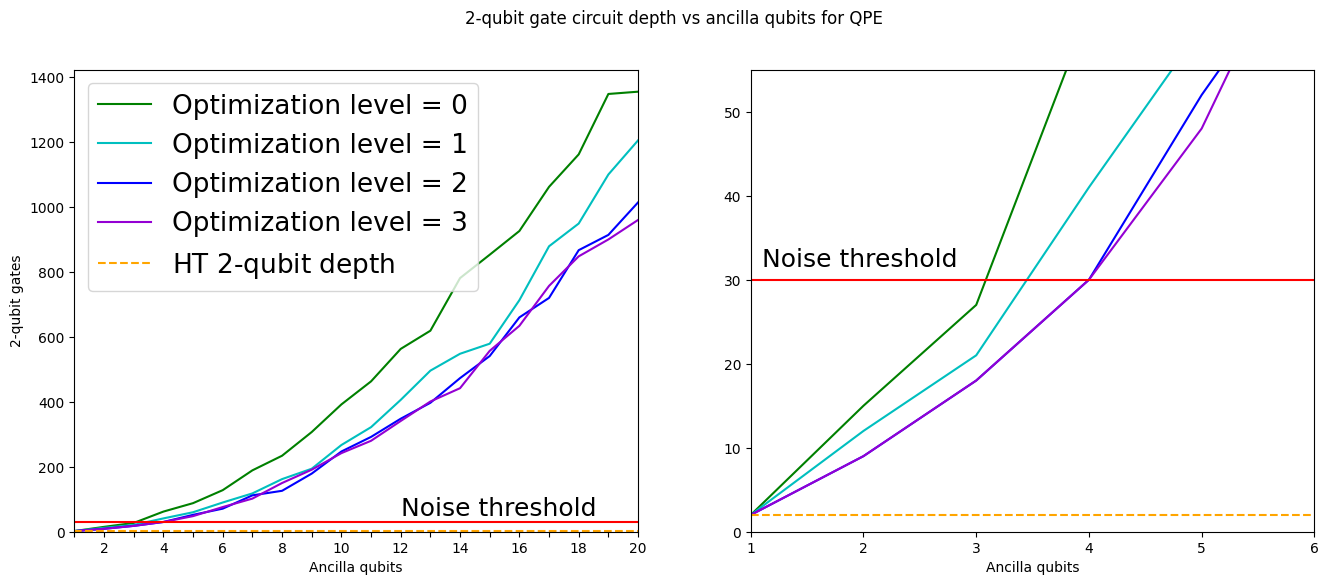

In [268]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(anc_bit, depth0, 'g', ls = '-', label = 'Optimization level = 0')
axes[0].plot(anc_bit, depth1, 'c', ls = '-', label = 'Optimization level = 1')
axes[0].plot(anc_bit, depth2, 'b', ls = '-', label = 'Optimization level = 2')
axes[0].plot(anc_bit, depth3, 'darkviolet', ls = '-', label = 'Optimization level = 3')
axes[0].set_xticks(anc_bit)

for label in axes[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

val = str(depth3[3])

axes[0].axhline(y=depth3[3], color='r', linestyle='-')
axes[0].axhline(y=2, color='orange', linestyle='--', label = 'HT $2$-qubit depth')
axes[0].text(12, 50, "Noise threshold", fontsize = 18, color = 'k')
axes[0].set_ylim(0)
axes[0].set_xlim(1,20)

fig.suptitle('2-qubit gate circuit depth vs ancilla qubits for QPE')
axes[0].legend(loc='upper left', fontsize = 19)
axes[0].set_xlabel('Ancilla qubits')
axes[0].set_ylabel('2-qubit gates')

axes[1].set_xlabel('Ancilla qubits')

axes[1].plot(anc_bit, depth0, 'g', ls = '-', label = 'Optimization level $= 0$')
axes[1].plot(anc_bit, depth1, 'c', ls = '-', label = 'Optimization level $= 1$')
axes[1].plot(anc_bit, depth2, 'b', ls = '-', label = 'Optimization level $= 2$')
axes[1].plot(anc_bit, depth3, 'darkviolet', ls = '-', label = 'Optimization level $= 3$')
axes[1].set_xticks(anc_bit)

axes[1].axhline(y=depth3[3], color='r', linestyle='-')
axes[1].axhline(y=2, color='orange', linestyle='--', label = 'HT depth')
axes[1].text(1.1, 31.5, "Noise threshold", fontsize = 18, color = 'k')
axes[1].set_ylim(0,55)
axes[1].set_xlim(1,6)

plt.show()
fig.tight_layout()